# **Práctica 1.1:**
**Análisis del impacto de la pandemia en la salud mental de usuarios de Redes Sociales**

## **Apartado 0:**

En primer lugar debemos **incluir** en este `notebook` todas las librerías que vayamos a utilizar para el desarrollo de la práctica. Cabe destacar que utilizaremos la librería de python Twint para obtener datos de forma masiva sin  utilizar la API oficial de Twitter.

In [2]:
import twint
import nest_asyncio
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import dask.dataframe as dd
import multiprocessing
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap

# Necesario para que no se quede colgado durante la búsqueda mediante Twint
nest_asyncio.apply()


## **Apartado 1:**

En primer lugar lo que tenemos que hacer es **obtener todos los tweets posibles que hablen de un determinado tema** (p.ej. Afghanistan). Para esto como se puede ver en el fragmento de código mostrado a continuación establecemos como el término de la búsqueda "Afghanistan", el fichero **.csv** en el que se guardarán los resultados como 'afghanistan.csv', el idioma de los tweets para obtener en inglés (aunque esta opción parece no funcionar ya que se nos devuelven tweets en varios idiomas) y un límite al número de tweets que recuperar igual a 150.000.

Lo siguiente es ejecutar esta búsqueda y guardar los resultados en el fichero indicado para la salida:

In [3]:
# path_to_data = 'C:/Users/Andres/Documents/Data/MaBD/datasets'

# # Configuramos la búsqueda de tweets
# c = twint.Config()
# c.Search = "Afghanistan"
# c.Output = path_to_data + '/' + 'afghanistan.csv'
# c.Store_csv = True
# c.Lang = "en"
# c.Limit = 150000

# # Ejecutamos la búsqueda
# twint.run.Search(c)

## **Apartado 2:**

Los datos obtenidos ya se guardaron en formato **.csv** en el momento en que se llevó a cabo la búsqueda.

## **Apartado 3:**

En primer lugar lo que debemos hacer es cargar los datos en un DataFrame para poder llevar a cabo un poco de pre-procesado. En el caso de que alguno de los tweets que se obtuvo mediante el uso de la librería Twint sea un tweet citando a algún tweet previo o contenga algún tipo de enlace, aparecerá este enlace o la URL del tweet citado al final del tweet actual con el que estaremos trabajando. Esto puede dar problemas más adelante al analizar los tweets, por lo que **eliminaremos estos enlaces (URL)** ahora para evitar problemas después.

Para esto lo primero será cargar los datos del fichero 'afghanistan.csv' en un DataFrame:

In [4]:
path_to_data = 'C:/Users/Andres/Documents/Data/MaBD/datasets'

df_tweets = pd.read_csv(
    path_to_data + '/' + 'afghanistan.csv',
    usecols=['id', 'username', 'tweet', 'date', 'language'],
    dtype=str
)   


**Eliminamos los tweets que NO estén escritos en inglés**, para esto hacemos uso del campo `language` del DataFrame obtenido: 

In [5]:
df_tweets = df_tweets[df_tweets.language == 'en']


Y ahora recorremos cada uno de los tweets presentes en el corpus y **eliminamos las URL** presentes en cada tweet:

In [6]:
# Definimos el corpus a utilizar a partir del DataFrame definido previamente
corpus = df_tweets.tweet.to_list()

# Recorremos el corpus y eliminamos de cada tweet las URL existentes
corpus = [re.sub(r'https?:\/\/[^ ]*', '', tweet, flags = re.MULTILINE) for tweet in corpus]

# Por si acaso, eliminamos los tweets que quedaron vacíos (contenían solo una URL)
corpus = [tweet for tweet in corpus if tweet != '']


### **Apartado 3a:**

Ahora probaremos algunas de las funcionalidades de la librería `scikit-learn`. Para esto haremos uso de alguno de los ejemplos presentes en la documentación de dicha librería para familiarizarnos un poco con las funciones que ofrece para análisis de texto.

In [7]:
vectorizer = CountVectorizer()

# Definimos el corpus de prueba con el que trabajaremos
corpus_example = [
    'This is the first document.',
    'This is the second second document.',
    'And the third one.',
    'Is this the first document?',
]

# Se ejecuta el `fit` que aprende todos los tokens presentes en los documentos seguido del `transform`
X = vectorizer.fit_transform(corpus_example)

# Imprimimos la matriz del documento
X.toarray()


array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 2, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]], dtype=int64)

Podemos obtener un poco más de información acerca de la matriz del documento generada si generamos un DataFrame que nos permita ver para cada una de las columnas, cuál es la palabra o *token* asociada a esta columna:

In [8]:
# Creamos el DataFrame
X_df = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
X_df.head()


,and,document,first,is,one,second,the,third,this
0,0,1,1,1,0,0,1,0,1
1,0,1,0,1,0,2,1,0,1
2,1,0,0,0,1,0,1,1,0
3,0,1,1,1,0,0,1,0,1


También podemos pasarle una lista con *stopwords*. Estas *stopwords* son palabras muy comunes en un idioma y que no aportan valor al análisis del corpus. Por lo tanto se las pasamos al vectorizador para que estas palabras sean eliminadas de los *tokens* resultantes. Usaremos las *stopwords* presentes en la librería `nltk`, que son las siguientes:

In [9]:
# Es necesario descargar las stopwords la primera que se vayan a utilizar
nltk.download("stopwords")
print(stopwords.words('english'))


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andres\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Si ejecutamos lo mismo pero **descartando las *stopwords*** obtenemos el siguiente resultado:

In [10]:
vectorizer2 = CountVectorizer(stop_words = stopwords.words('english'))

# Se ejecuta el `fit` que aprende todos los tokens presentes en los documentos seguido del `transform`
X = vectorizer2.fit_transform(corpus_example)

# Creamos el DataFrame
X_df = pd.DataFrame(X.toarray(), columns = vectorizer2.get_feature_names())
X_df.head()


,document,first,one,second,third
0,1,1,0,0,0
1,1,0,0,2,0
2,0,0,1,0,1
3,1,1,0,0,0


Y si ahora ejecutamos a continuación mediante la clase `TfidfVectorizer()` podemos convertir el corpus, que por ahora es una lista con cuatro strings de ejemplo, a la matriz con los **valores TF-IDF** para cada una de las palabras presentes en el mismo. Es el equivalente a ejecutar el `CountVectorizer` seguido del `TfidfTransformer`.

In [11]:
# Convierte el corpus a una matriz TF-IDF
vectorizer = TfidfVectorizer(
    stop_words=stopwords.words('english'), 
    use_idf=True
)
X = vectorizer.fit_transform(corpus_example)

# Creamos el DataFrame
X_df = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
X_df.head()


,document,first,one,second,third
0,0.629228,0.777221,0.000000,0.000000,0.000000
1,0.304035,0.000000,0.000000,0.952661,0.000000
2,0.000000,0.000000,0.707107,0.000000,0.707107
3,0.629228,0.777221,0.000000,0.000000,0.000000


### **Apartado 3b:**

Ahora podremos **contestar a las preguntas del enunciado** mediante el uso del `TfidfVectorizer`. En primer lugar, lo que haremos es, a partir del corpus obtenido mediante el uso de la librería Twint y considerando cada tweet como un documento individual, utilizar el `TfidfVectorizer` para vectorizar la colección y **mostrar los 50 términos cuya suma acumulada de TF-IDF sobre todos los documentos sea mayor**.

Para esto lo primero será calcular la matriz con los valores TF-IDF. Cabe recordar que filtraremos las *stopwords* y todas aquellas palabras que aparezcan en menos de 10 documentos.

In [12]:
vectorizer = TfidfVectorizer(
    stop_words=stopwords.words('english'),
    strip_accents='unicode',
    min_df=10,
    use_idf=True
)
X = vectorizer.fit_transform(corpus)


Podemos ahora visualizar las primeras filas de la **matriz TF-IDF** generada:

In [13]:
## Creamos el DataFrame
X_df = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
X_df.head()


,00,000,0093786404494,00pm,01,02,03,04,05,06,...,الله,اگیا,سے,مارخور,مزا,معاہدہ_پوراکروسفیرنکالو,پھر,ओ_द,श_बच,सप
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Como se puede ver, estas primeras filas de la matriz TF-IDF generada no nos aportan prácticamente nada de información.

Ahora, para encontrar las 50 palabras más 'centrales' lo que debemos hacer es **sumar el valor TF-IDF de cada una de las palabras para todos los documentos presentes en el corpus**:

In [14]:
# Definimos el número de palabras más centrales que queremos consultar
n_words_to_retrieve = 50

# Sumamos el valor TF-IDF de cada palabra
X_sum_by_column = np.array(np.sum(X, axis=0)).flatten()

# Obtenemos los índices de las n_words_to_retrieve palabras más centrales
indices = (-X_sum_by_column).argsort()[:n_words_to_retrieve]

# Obtenemos las palabras
words = np.take(vectorizer.get_feature_names(), indices)


Por lo tanto las **50 palabras más 'centrales'** son las siguientes:

In [15]:
print(words)


['afghanistan' 'pakistan' 'well' 'team' 'played' 'taliban' 'pakvsafg'
 't20worldcup' 'win' 'india' 'match' 'us' 'cricket' 'world' 'people' 'amp'
 'like' 'congratulations' 'scotland' 'good' 'americans' 'biden' 'today'
 'one' 'acbofficials' 'afghan' 'vs' 'game' 'country' 'cup' 'still' 'love'
 't20' 'afgvpak' 'therealpcb' 'time' 'first' 'news' 'best' 'would' 'get'
 'new' 'pak' 'great' 'left' 'pakvafg' 'go' 'support' 'war' 'asif']


Entre las palabras más **'centrales'** del corpus podemos ver bastantes palabras que podríamos haber esperado que estuviesen aquí, como pueden ser 'afghanistan', 'pakistan', 'biden' o 'taliban'. Otras sin embargo, sorprenden más por su aparición al no estar aparentemente relacionadas con el tema, como pueden ser 'scotland' o 'cricket'.

A mayores, también mostraremos **los 100 términos más repetidos en la colección**, es decir, las 100 palabras cuya suma de sus valores TF para todos los documentos sea mayor:

In [16]:
vectorizer = TfidfVectorizer(
    stop_words=stopwords.words('english'),
    strip_accents='unicode',
    min_df=10,
    use_idf=False
)
X = vectorizer.fit_transform(corpus)

# Definimos el número de palabras más repetidas que queremos consultar
n_words_to_retrieve = 100

# Sumamos el valor TF de cada palabra
X_sum_by_column = np.array(np.sum(X, axis=0)).flatten()

# Obtenemos los índices de las n_words_to_retrieve palabras más repetidas
indices = (-X_sum_by_column).argsort()[:n_words_to_retrieve]

# Obtenemos las palabras
words = np.take(vectorizer.get_feature_names(), indices)


Por lo tanto, las 100 palabras más repetidas son las siguientes:

In [17]:
print(words)


['afghanistan' 'pakistan' 'team' 'taliban' 'well' 'played' 'us' 'pakvsafg'
 't20worldcup' 'people' 'india' 'amp' 'world' 'cricket' 'match' 'win'
 'like' 'biden' 'americans' 'one' 'afghan' 'scotland' 'country' 'good'
 'today' 'still' 'game' 'congratulations' 'vs' 'cup' 't20' 'acbofficials'
 'time' 'afgvpak' 'get' 'would' 'love' 'news' 'first' 'war' 'left' 'new'
 'china' 'also' 'pak' 'best' 'support' 'even' 'go' 'great' 'going'
 'therealpcb' 'help' 'see' 'crisis' 'back' 'pakvafg' 'need' 'asif' 'women'
 'think' 'ali' 'afghans' 'know' 'border' 'government' 'better' 'really'
 'could' 'many' 'want' 'live' 'take' 'iraq' 'done' 'way' 'next' 'via'
 'right' 'afgvsco' 'beat' 'state' 'last' 'make' 'let' 'years' 'military'
 'much' 'luck' 'trump' 'humanitarian' 'please' 'countries' 'icc' 'iran'
 'american' 'kabul' 'never' 'day' 'victory']


## **Apartado 4:**

Ahora procederemos a cargar y filtrar la colección de tweets generalista localizados en EEUU y alrededores durante el año 2020 y el año 2021. Usaremos estos tweets para realizar el **análisis sobre la salud mental durante la pandemia**. Lo primero será cargar los datos. Para esto lo primero que haremos será cargar en dos DataFrame diferentes los datos de cada uno de los ficheros **.csv** que contienen los tweets.

Después procesaremos cada uno de estos DataFrames para eliminar aquellos tweets que no estén en inglés y para eliminar las URL's presentes en los tweets. Por lo tanto, el primer paso es **cargar los datos en dos DataFrames**:


In [3]:
path_to_data = 'C:/Users/Andres/Documents/Data/MaBD/datasets/US_data'

df_jan2020_jul2020_us = pd.read_csv(
    path_to_data + '/' + 'jan2020_jul2020_us.csv',
    usecols=['id', 'username', 'tweet', 'date', 'language'],
    dtype=str
)

df_jul2020_may2021_us = pd.read_csv(
    path_to_data + '/' + 'jul2020_may2021_us.csv',
    usecols=['id', 'username', 'tweet', 'date', 'language'],
    dtype=str
)


Unimos los dos DataFrames en uno solo mediante el uso de la función `pd.concat()` para tener en un solo DataFrame los tweets de enero de 2020 a mayo de 2021:

In [4]:
df_jan2020_may2021_us = pd.concat(
    [df_jan2020_jul2020_us, df_jul2020_may2021_us],
    axis=0,
    ignore_index=True
)


Después de cargar los datos debemos volver a filtrar aquellos tweets que no estén en inglés y eliminarlos del DataFrame:

In [5]:
df_jan2020_may2021_us = df_jan2020_may2021_us[df_jan2020_may2021_us.language == 'en']


Al igual que antes eliminamos las URL's de los tweets con los que trabajaremos:

In [6]:
# Recorremos el corpus y eliminamos de cada tweet las URL existentes
df_jan2020_may2021_us['tweet'] = [re.sub(
    r'https?:\/\/[^ ]*', '', tweet, flags=re.MULTILINE) for tweet in df_jan2020_may2021_us.tweet]

# Por si acaso, eliminamos los tweets que quedaron vacíos (contenían solo una URL)
df_jan2020_may2021_us['tweet'] = [
    tweet for tweet in df_jan2020_may2021_us.tweet if tweet != '']


## **Apartado 5:**

Ahora lo que haremos es llevar a cabo el **análisis de los tweets** utilizando la librería VADER. Esto nos dará una idea de la positividad, neutralidad o negatividad de los tweets publicados a lo largo de la pandemia.

En cuanto al tema de la memoria y del tiempo de cómputo, **haremos uso de la librería Dask** para ejecutar de forma paralelizada el cálculo del `compound` para cada uno de los tweets y almacenaremos este valor en una nueva columna del DataFrame original.

In [7]:
analyzer = SentimentIntensityAnalyzer()

# Ejecutamos utilizando la librería Dask para minimizar el tiempo de cómputo
df_jan2020_may2021_us['compound'] = dd.from_pandas(
    df_jan2020_may2021_us.tweet,
    npartitions=4*multiprocessing.cpu_count()
).map_partitions(
    lambda dframe: dframe.apply(
        lambda x: analyzer.polarity_scores(x)['compound']
    )
).compute(scheduler='processes')


Llegados a este punto ya tenemos calculado el valor del *compound* para cada uno de los tweets presentes en el DataFrame con el que estamos trabajando. Combiene recordar que el valor del *compound* se representa en el intervalo [-1, 1], siendo los valores cercanos a -1 los más negativos mientras que los valores cercanos a 1 son los más positivos. 

Como dice en la propia documentación de VADER, el *compound* es la métrica más útil si se quiere hacer uso de una medida unidimensional que mida el sentimiento para una oración dada. En la documentación se establecen tres umbrales típicos diferentes para clasificar una oración como negativa, neutral y positiva. 

Estos umbrales son los siguientes:

- Sentimiento positivo: *compound* >= 0.05
- Sentimiento neutral: (*compound* > -0.05) and (*compound* < 0.05)
- Sentimiento negativo: *compound* <= -0.05

Una vez calculado el *compound* para cada uno de los tweets guardamos este nuevo DataFrame como un fichero **.csv** para poder acceder a esta información en adelante sin necesidad de volver a realizar el cálculo completo:

In [23]:
# path_to_data = 'C:/Users/Andres/Documents/Data/MaBD/datasets/US_data'

# # Almacenamos el datagrame en un fichero .csv
# df_jan2020_may2021_us.to_csv(
#     path_or_buf=path_to_data + '/' + 'jan2020_may2021_us.csv',
#     sep=',',
#     na_rep='',
#     encoding='utf-8',
#     index=False)


Para leer el contenido de este fichero ejecutamos la siguiente celda de código (es importante indicarle a la función `read_csv()` que la columna 'compound' es de tipo `float`):

In [3]:
# path_to_data = 'C:/Users/Andres/Documents/Data/MaBD/datasets/US_data'

# df_jan2020_may2021_us = pd.read_csv(
#     path_to_data + '/' + 'jan2020_may2021_us.csv',
#     usecols=['id', 'username', 'tweet', 'date', 'language', 'compound'],
#     dtype={'id': str, 'username': str, 'tweet': str, 'date': str, 'language': str, 'compound': float}
# ).sort_values(by='date')


Mostramos las primeras columnas del DataFrame resultante:

In [25]:
df_jan2020_may2021_us.head()


,id,date,username,tweet,language,compound
0,1417273043513090057,2021-07-20,longasucan2,@jan_forney This NSO Pegasus story needs a dee...,en,0.6369
1,1417273042171015169,2021-07-20,pulsara,Many medics don’t encounter pediatric patients...,en,-0.5367
2,1417273042149969923,2021-07-20,hbradio_lv,NOW PLAYING Lil Nas X ( @LILNASX ) - Panini,en,0.3680
3,1417273041936072707,2021-07-20,lightsoutstarr,Carl Froch was and is a top fighting man,en,-0.1779
4,1417273040363261954,2021-07-20,chuckwtf,@r8dr4lfe75 I thought Otis was an elevator.,en,0.0000


## **Apartado 6:**

Para llevar a cabo la **representación gráfica del sentimiento descubierto** durante el apartado anterior representaremos la media de los valores del *compound* de todos los tweets publicados por semana. 

Probaremos a ver cómo quedan los datos representados mediante esta granularidad. En caso de que parezca insuficientemente precisa, es decir, que no se aprecien bien los cambios en el sentimiento, probaremos a representar los datos por días. No se escogió representar los datos por meses ya que esta granularidad presenta un intervalo de tiempo demasiado amplio y en el que casi por seguro perderíamos información relevante.

Por lo tanto, agrupamos nuestros datos a nivel de semana, para esto haremos uso de la función `resample()` de la librería `pandas`:

In [26]:
# Primero convertimos la columna 'date' de nuestro DataFrame al formato 'datetime'
df_jan2020_may2021_us['datetime'] = pd.to_datetime(df_jan2020_may2021_us.date) - pd.to_timedelta(7, unit='d')

# Agrupamos a nivel de semana, estableciendo el primer día de la semana a lunes (argumento W-MON)
jan2020_may2021_us_by_weeks = df_jan2020_may2021_us.resample(rule='W-MON', on='datetime')


Ahora que ya tenemos los datos agrupados por semanas, lo que debemos hacer es **calcular la media del valor del *compound*** para cada uno de los tweets que fuesen publicados en esa semana:

In [27]:
# Calculamos la media de los valores del compound para cada semana
jan2020_may2021_us_by_weeks = jan2020_may2021_us_by_weeks.compound.mean()
df_jan2020_may2021_us_by_weeks = jan2020_may2021_us_by_weeks.to_frame()

# Mostramos las primeras columnas para ver que el cálculo se representó correctamente
df_jan2020_may2021_us_by_weeks.head()


,compound
datetime,
2020-01-06,0.174797
2020-01-13,0.177021
2020-01-20,0.172562
2020-01-27,0.184303
2020-02-03,0.175521


Representamos la gráfica del la evolución del *compound* a lo largo de la pandemia:

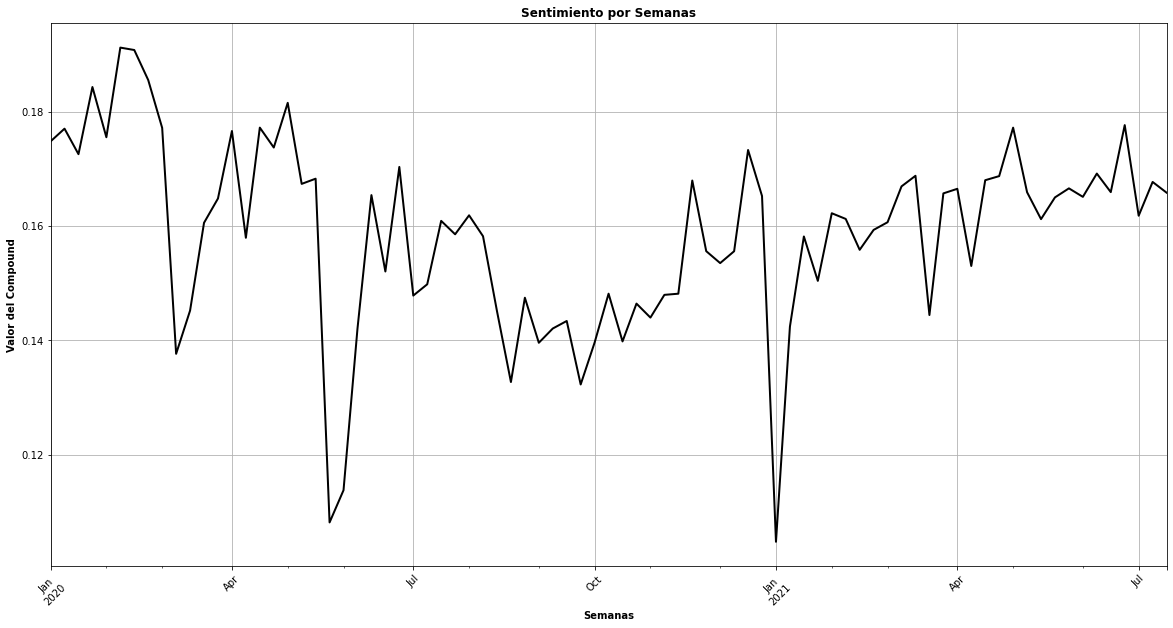

In [28]:
# Graficamos
ax = df_jan2020_may2021_us_by_weeks.plot(
    figsize=(20, 10),
    kind="line",
    rot=45,
    color='black',
    linewidth=2)
ax.grid()

# Añadimos estilo a la gráfica
ax.set_title("Sentimiento por Semanas", weight='bold')
ax.set_xlabel("Semanas", weight='bold')
ax.set_ylabel("Valor del Compound", weight='bold')

# Eliminamos la leyenda
ax.get_legend().remove()


Como se puede ver en la gráfica anterior parece que el nivel de detalle aportado al agrupar por semanas es suficiente para sacar conclusiones sobre el estado de ánimo de la gente basandonos en eventos de la pandemia, sin embargo, creo que **agrupando a nivel de día se podría conseguir un poco más de información**. 

Por lo tanto, representaremos esta misma gráfica a nivel de día. Para esto lo primero es volver a calcular la media del valor del *compound* para los tweets de cada uno de los días:

In [29]:
# Primero convertimos la columna 'date' de nuestro DataFrame al formato 'datetime'
df_jan2020_may2021_us['datetime'] = pd.to_datetime(df_jan2020_may2021_us.date)

# Agrupamos a nivel de día
jan2020_may2021_us_by_days = df_jan2020_may2021_us.resample(rule='1D', on='datetime')

# Calculamos la media de los valores del compound para cada día
jan2020_may2021_us_by_days = jan2020_may2021_us_by_days.compound.mean()
df_jan2020_may2021_us_by_days = jan2020_may2021_us_by_days.to_frame()


Ahora **representaremos de nuevo la evolución del sentimiento a lo largo de la pandemia**. Cabe dejar claro que se tomaron **dos** decisiones a la hora de representar esta gráfica para que sea más sencillo llevar a cabo su interpretación. La primera de estas decisiones es la de suavizar el valor medio del *compound* diario (calculándolo como la media del valor de ese día junto con el valor de los dos días anteriores) para evitar picos muy bruscos y que la gráfica presente una mejor continuidad, mientras que la segunda decisión fue la pintar la gráfica con un gradiente de colores de rojo (valores del *compound* más bajos) a verde (valores más altos).

Para suavizar el valor diario del *compound* primero debemos procesar el DataFrame anterior:

In [30]:
# Suavizamos el valor del 'compound'
df_jan2020_may2021_us_by_days['smooth_compound'] = df_jan2020_may2021_us_by_days['compound'].rolling(
    3).mean()
df_jan2020_may2021_us_by_days['smooth_compound'].fillna(
    df_jan2020_may2021_us_by_days['compound'], inplace=True)


Finalmente, **mostramos la gráfica para la evolución del sentimiento** en Estados Unidos durante la pandemia:

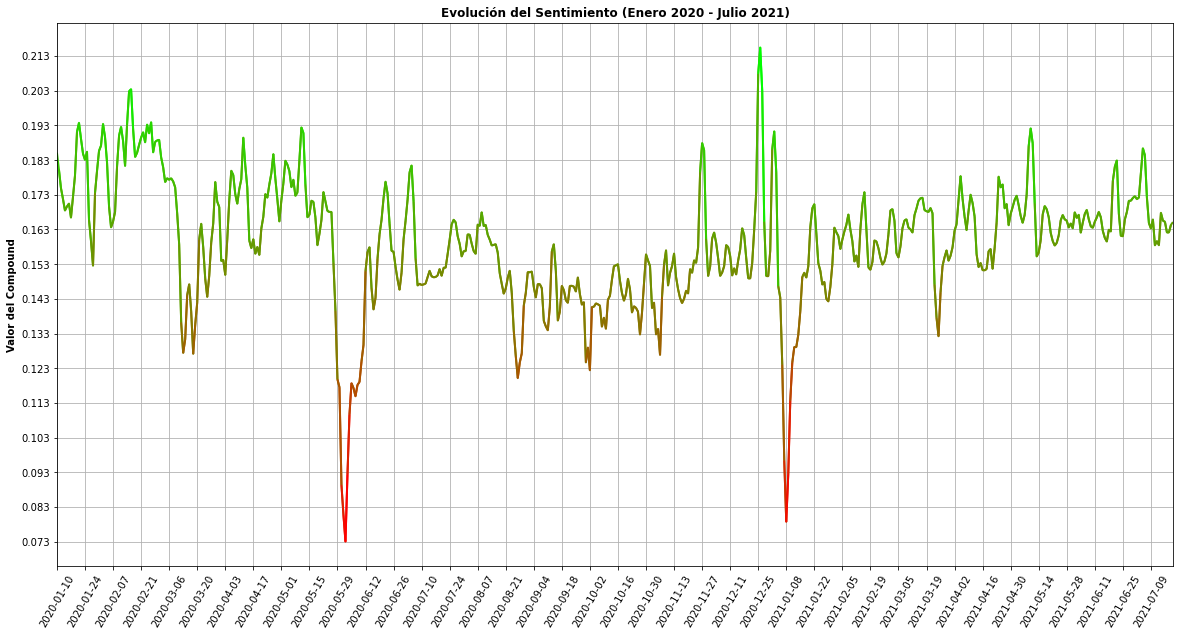

In [31]:

def graph_sentiment_evolution():
    n_days = df_jan2020_may2021_us_by_days.shape[0]

    # Definimos los valores que queremos representar en cada eje
    x = np.arange(0, n_days, 1)
    y = df_jan2020_may2021_us_by_days['smooth_compound']

    # Definimos un gradiente de color del rojo al verde
    cmap = LinearSegmentedColormap.from_list("", [(1, 0, 0), (0, 1, 0)])

    # Definimos los segmentos a representar
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-2], points[1:-1], points[2:]], axis=1)

    # Le asignamos un color a cada uno de los segmentos en función de los valores del eje y
    lc = LineCollection(segments, cmap=cmap, linewidth=2)
    lc.set_array(y)

    # Graficamos
    fig, ax = plt.subplots(figsize=(20, 10), ncols=1, nrows=1)
    ax.add_collection(lc)
    ax.grid()
    ax.autoscale()
    ax.set_xlim(x.min(), x.max())

    # Definimos los xticks a representar
    xticks = np.arange(0, n_days, 14)
    xticks_labels = jan2020_may2021_us_by_days.index.astype(str).to_frame().iloc[xticks]

    # Añadimos estilo a los ejes
    ax.set_yticks(np.arange(y.min(), y.max(), 0.01))
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks_labels.datetime, rotation=60)

    # Añadimos texto a la gráfica
    ax.set_title("Evolución del Sentimiento (Enero 2020 - Julio 2021)", weight='bold')
    ax.set_ylabel("Valor del Compound", weight='bold')

graph_sentiment_evolution()


Hablaré sobre las conclusiones que se pueden extraer de esta gráfica en el **apartado siguiente**, en el cual, añadiendo los datos de los contagios a lo largo del tiempo, podremos extraer mejores conclsuiones.

## **Apartado 7:**

En este apartado, usaremos el dataset descargado de [https://covid.cdc.gov/covid-data-tracker/#trends_dailycases](https://covid.cdc.gov/covid-data-tracker/#trends_dailycases) con los datos sobre el número de contagios diarios en Estados Unidos durante la pandemia para añadir **la curva con la incidencia acumulada a 7 días** (*7-Day Moving Avg* en el dataset) a los datos sobre el sentimiento descubiertos en el apartado anterior, para poder sacar mejores conclusiones.

Para esto lo primero es cargar los datos del fichero **.csv** descargado y pre-procesar este DataFrame para que tenga el formato adecuado para llevar a cabo la representación de los datos:

In [32]:
df_daily_case_trends_us = pd.read_csv(
    path_to_data + '/' + 'data_table_for_daily_case_trends__the_united_states.csv',
    usecols=['Date','7-Day Moving Avg'],
    dtype={'Date': str, '7-Day Moving Avg': int}
)

# Formateamos el DataFrame con los datos sobre los casos de covid
df_daily_case_trends_us['datetime'] = pd.to_datetime(df_daily_case_trends_us['Date'])
df_daily_case_trends_us.drop(columns='Date', inplace=True)
df_daily_case_trends_us.set_index('datetime', inplace=True)
df_daily_case_trends_us.sort_index(inplace=True)


Lo siguiente que debemos hacer es eliminar tanto de este nuevo DataFrame, como del DataFrame con los datos de sentimientos agrupados por días, los días para las cuáles **no contemos con información para las dos variables** que queremos representar. Esto lo hacemos en la siguiente celda de código:

In [33]:
# Definimos el primer y el último día para el que tenemos datos de sentimientos y de covid
start_date = max(jan2020_may2021_us_by_days.first_valid_index(), df_daily_case_trends_us.first_valid_index())
end_date = min(jan2020_may2021_us_by_days.last_valid_index(), df_daily_case_trends_us.last_valid_index())

# Eliminamos los días que queden fuera de este rango
df_jan2020_may2021_us_by_days = df_jan2020_may2021_us_by_days[df_jan2020_may2021_us_by_days.index >= start_date]
df_jan2020_may2021_us_by_days = df_jan2020_may2021_us_by_days[df_jan2020_may2021_us_by_days.index <= end_date]
df_daily_case_trends_us = df_daily_case_trends_us[df_daily_case_trends_us.index >= start_date]
df_daily_case_trends_us = df_daily_case_trends_us[df_daily_case_trends_us.index <= end_date]


Finalmente, presentamos **la gráfica que muestra la evolución del sentimiento encontrada en el apartado anterior y la incidencia acumulada a 7 días a lo largo de la pandemia**:

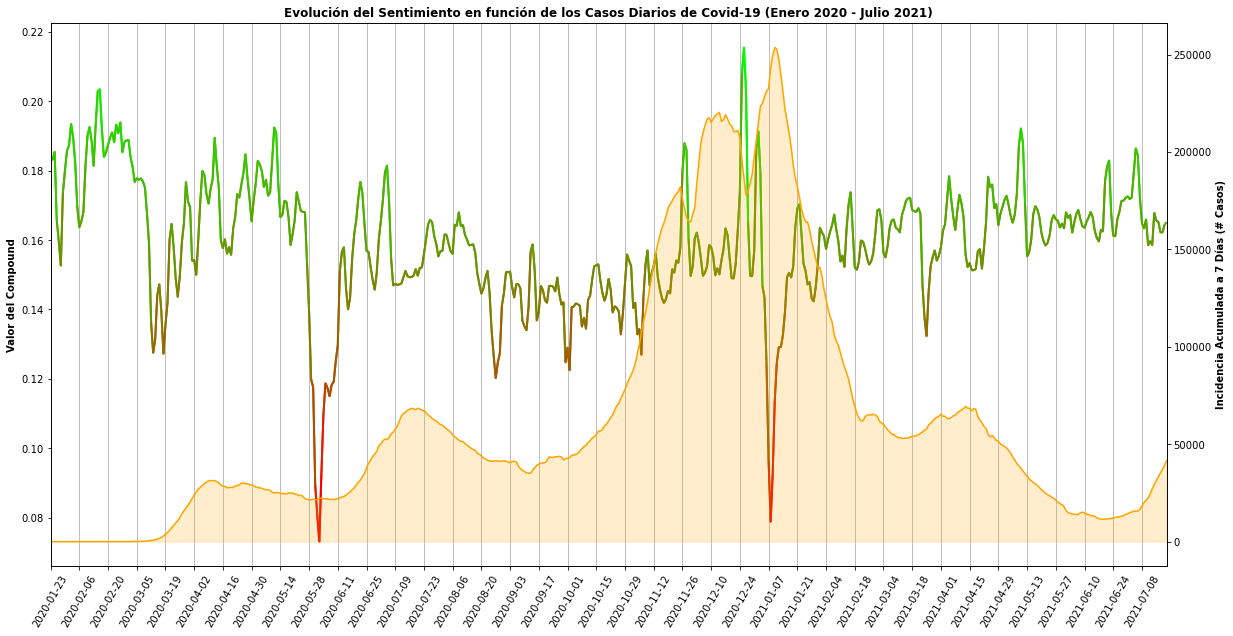

In [34]:
def grap_sentiment_and_covid():
    # Definimos el número de días a representar
    n_days = df_jan2020_may2021_us_by_days.shape[0]

    # Definimos los valores que queremos representar en cada eje
    x = np.arange(0, n_days, 1)
    y_ax1 = df_jan2020_may2021_us_by_days['smooth_compound']
    y_ax2 = df_daily_case_trends_us['7-Day Moving Avg']

    # Definimos un gradiente de color del rojo al verde
    cmap = LinearSegmentedColormap.from_list("", [(1, 0, 0), (0, 1, 0)])

    # Definimos los segmentos a representar
    points = np.array([x, y_ax1]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-2], points[1:-1], points[2:]], axis=1)

    # Le asignamos un color a cada uno de los segmentos en función de los valores del eje y
    lc = LineCollection(segments, cmap=cmap, linewidth=2)
    lc.set_array(y_ax1)

    # Representamos los datos de sentimientos
    fig, ax1 = plt.subplots(figsize=(20, 10), ncols=1, nrows=1)
    ax1.add_collection(lc)
    ax1.xaxis.grid(True)
    ax1.autoscale()
    ax1.set_xlim(x.min(), x.max())

    # Definimos los xticks a representar
    xticks = np.arange(0, n_days, 14)
    xticks_labels = df_jan2020_may2021_us_by_days.index.astype(str).to_frame().iloc[xticks]

    # Añadimos estilo al eje x
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xticks_labels.datetime, rotation=60)

    # Instanciamos un segundo ax que comparte el eje x con el anterior
    ax2 = ax1.twinx()

    # Representamos los datos de covid
    ax2.plot(x, y_ax2, color='orange')
    ax2.fill_between(x, y_ax2, color='orange', alpha=0.2)
    ax2.autoscale()

    # Añadimos texto a la gráfica
    ax1.set_title("Evolución del Sentimiento en función de los Casos Diarios de Covid-19 (Enero 2020 - Julio 2021)", weight='bold')
    ax1.set_ylabel("Valor del Compound", weight='bold')
    ax2.set_ylabel('Incidencia Acumulada a 7 Días (# Casos)', weight='bold')

grap_sentiment_and_covid()


Ahora podremos sacar las concuclusiones sobre cuáles fueron las causan en los cambios en el sentimiento de la gente a lo largo de la pandemia en Estados Unidos entre Enero de 2020 y Julio de 2021. En primer lugar, debemos dejar claro que el valor mínimo para el *compound* medio de un día a lo largo de todo este período de tiempo es de 0,0496. Teniendo en cuenta que se considera como positivo todo aquello que tenga un valor para el *compound* mayor a 0,05; se podría decir que, en general, el sentimiento a lo largo de la pandemia se mantuvo positivo, rozando sólo para sus valores mínimos el sentimiento neutral.

Ahora procederemos a analizar la gráfica del sentimiento. Como se puede ver, durante las primeras semanas el sentimiento se mantuvo estable entre el 0,16 y el 0,20 (sentimiento positivo) cuando entre el 05-03-2020 y el 19-03-2020 tiene una bajada hasta un valor de entre el 0,12 y el 0,14. Esta bajada se corresponde con el inicio de la pandemia y el aumento incial en los casos de coronavirus. Consultando en [https://www.ajmc.com/view/a-timeline-of-covid19-developments-in-2020](https://www.ajmc.com/view/a-timeline-of-covid19-developments-in-2020) podemos ver como esta bajada en el sentimiento también se corresponde con la declaración de que el covid-19 constituye una pandemia por parte de la OMS y con la declaración del estado de emergencia por parte del gobierno de Estados Unidos.

Durante las siguientes semanas el sentimiento vuelve a aumentar hasta alcanzar valores similares a los anteriores a la bajada de marzo. Durante algo más de dos meses se mantiene relativamente estable hasta que se produce, entre el 28-05-2020 y el 11-06-2020, la mayor bajada en el sentimiento durante todo el periodo que estamos estudiando. En estas fechas no se aprecia una subida significativa en la incidencia acumulada a 7 días, sin embargo, durante estas fechas es cuando se llegan a las 100.000 muertes y a los 2.000.000 millones de casos, lo cual tuvo repercusión en el ánimo de la gente.

Tras esta gran bajada el sentimiento aumenta ligeramente, pero sin llegar a los valores previos a la pandemia. Aquí, a finales de octubre, los casos empiezan a crecer con rápidez. Hay dos momentos en los que parece que los casos empiezan a descender para después volver a crecer. Durante estas dos bajadas en el número los casos, producidas entre el 26-11-2020 y el 21-01-2021, también se ve mejoras en el aumento de la gente. A pesar de esto, sobre 07-01-2021 se alcanza el valor más alto para la incidencia acumulada a 7 días vista durante toda la pandemia, que se traduce en una gran bajada en el sentimiento de la gente, que baja a valores cercanos al 0,08. Esta bajada en el sentimiento también coincide con el momento en que la variante británica empieza a expandirse por Estados Unidos.

Tras este pico máximo, los casos vuelven a descender y el sentimiento se estabiliza en valores de entre 0,12 y 0,20 durante el resto de la pandemia, hasta julio de 2021.